In [1]:
# Import libraries
import os
import datacube
import folium
import numpy as np
import xarray as xr
import geopandas as gpd
from pystac.client import Client
import matplotlib.pyplot as plt
from odc.stac import load
from odc.algo import mask_cleanup
from datacube.utils.masking import valid_data_mask
from datacube_compute import geomedian_with_mads  
from odc.geo.geom import point, BoundingBox

In [2]:
# Connect to ODC
dc = datacube.Datacube(app="geomad_s2")

In [31]:
if "AWS_DEFAULT_REGION" in os.environ:
    del os.environ["AWS_DEFAULT_REGION"]
aoi = -4.082472, 137.133031
aoi_point = point(aoi[1], aoi[0], crs="EPSG:4326")
bbox = aoi_point.buffer(0.05).boundingbox
bbox.explore(zoom=8)

In [32]:
# Set the Query and area of interest
start_date = "2025-01-01"
end_date = "2025-12-30"

# Find and load Sentinel-2 datasets
sentinel2_datasets = dc.find_datasets(
    product=["s2_l2a"],
    time=(start_date, end_date),
    longitude=(bbox.left, bbox.right),
    latitude=(bbox.bottom, bbox.top),
    cloud_cover=(0, 80),
)

print(f"Found {len(sentinel2_datasets)} Sentinel-2 datasets")

# Load available data
ds = dc.load(
    datasets=sentinel2_datasets,
    longitude=(bbox.left, bbox.right),
    latitude=(bbox.bottom, bbox.top), 
    measurements=["red", "green", "blue", "scl"], #"nir08", "swir16", "swir22", "scl"],
    dask_chunks={"x": 1000, "y": 1000, "time":-1}, 
    resolution=(-10,10),
    group_by="solar_day",
    output_crs="ESRI:54034",
    driver="rio",
)

print(ds)

Querying product Product(name='s2_l2a', id_=13)


Found 53 Sentinel-2 datasets
<xarray.Dataset> Size: 456MB
Dimensions:      (y: 1104, x: 1114, time: 53)
Coordinates:
  * y            (y) float64 9kB -4.455e+05 -4.455e+05 ... -4.565e+05 -4.566e+05
  * x            (x) float64 9kB 1.526e+07 1.526e+07 ... 1.527e+07 1.527e+07
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 424B 2025-01-07T01:18:18.251000 ... 20...
Data variables:
    red          (time, y, x) uint16 130MB dask.array<chunksize=(53, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) uint16 130MB dask.array<chunksize=(53, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) uint16 130MB dask.array<chunksize=(53, 1000, 1000), meta=np.ndarray>
    scl          (time, y, x) uint8 65MB dask.array<chunksize=(53, 1000, 1000), meta=np.ndarray>


In [26]:
from odc.algo import enum_to_bool, erase_bad
from odc.algo import mask_cleanup

ds.scl.attrs['flags_definition'] = dc.list_measurements().loc[('s2_l2a', 'scl')].flags_definition
cloud_filters= {"cloud medium probability":[["opening", 5], ["dilation", 5]], "cloud high probability":[["opening", 5], ["dilation", 5]], "thin cirrus":[["dilation", 5]]}
#cloud_filters= {"cloud shadows":[["dilation", 5]], "cloud medium probability":[["opening", 5], ["dilation", 5]], "cloud high probability":[["opening", 5], ["dilation", 5]], "thin cirrus":[["dilation", 5]]}
#cloud_filters= {"cloud medium probability":[["dilation", 5]], "cloud high probability":[["dilation", 5]], "thin cirrus":[["dilation", 5]]}
# Apply the same cloud filter
# Erase Data Pixels for which mask == nodata
mask = ds["scl"]
bad = enum_to_bool(mask, ("no data",))
for cloud_class, c_filter in cloud_filters.items():
    if not isinstance(cloud_class, tuple):
        cloud_class = (cloud_class,)
        cloud_mask = enum_to_bool(mask, cloud_class)
        cloud_mask_buffered = mask_cleanup(cloud_mask, mask_filters=c_filter)
        bad = cloud_mask_buffered | bad

In [34]:
data = ds.where(~bad).drop_vars("scl")
print(data)

<xarray.Dataset> Size: 4B
Dimensions:      (time: 0, y: 0, x: 0)
Coordinates:
  * y            (y) float64 0B 
  * x            (x) float64 0B 
  * time         (time) datetime64[ns] 0B 
    spatial_ref  int32 4B 0
Data variables:
    red          (time, y, x) float32 0B dask.array<chunksize=(0, 0, 0), meta=np.ndarray>
    green        (time, y, x) float32 0B dask.array<chunksize=(0, 0, 0), meta=np.ndarray>
    blue         (time, y, x) float32 0B dask.array<chunksize=(0, 0, 0), meta=np.ndarray>


In [35]:
%%time

gm_mads2 = geomedian_with_mads(data).compute()

gm_mads2

CPU times: user 39 s, sys: 1.59 s, total: 40.6 s
Wall time: 1min 19s


<xarray.Dataset> Size: 0B
Dimensions:  (x: 0, y: 0)
Coordinates:
  * x        (x) float64 0B 
  * y        (y) float64 0B 
Data variables:
    blue     (y, x) float32 0B 
    emad     (y, x) float32 0B 
    count    (y, x) uint16 0B 
    red      (y, x) float32 0B 
    bcmad    (y, x) float32 0B 
    green    (y, x) float32 0B 
    smad     (y, x) float32 0B

In [30]:
# Explore the results
m = folium.Map(location=aoi, zoom_start=12)
gm_mads2.odc.to_rgba(vmin=0, vmax=2000).odc.add_to(
    m, name="Complex Mask Median"
)
folium.LayerControl().add_to(m)

m

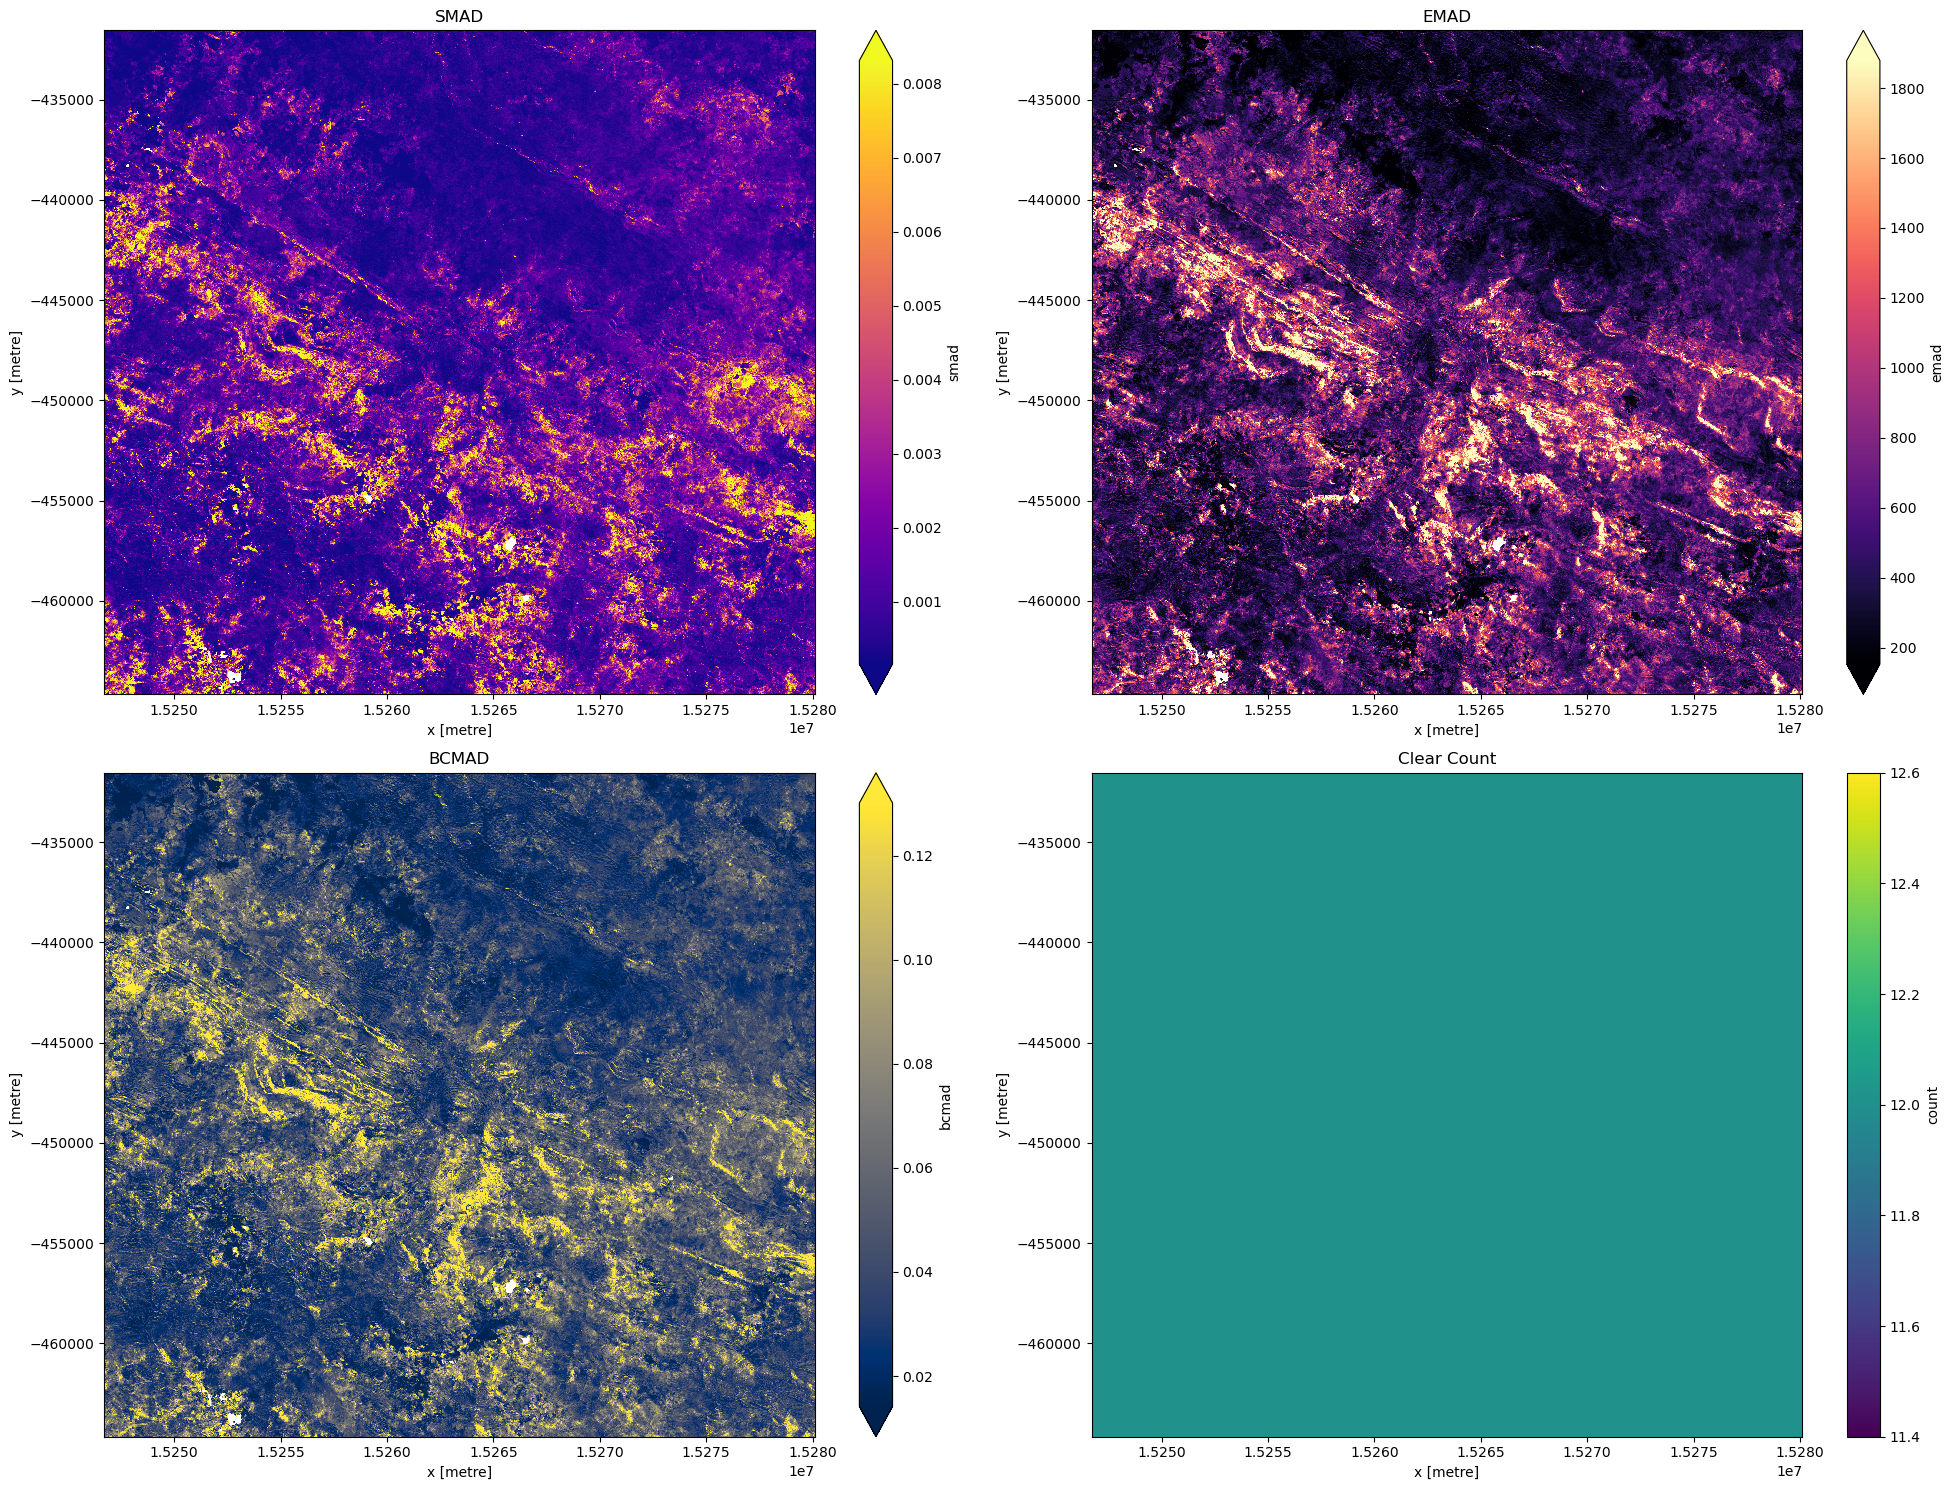

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# --- SMAD ---
gm_mads2['smad'].plot(ax=ax[0,0], cmap='plasma', robust=True)
ax[0,0].set_title('SMAD')

# --- EMAD ---
gm_mads2['emad'].plot(ax=ax[0,1], cmap='magma', robust=True)
ax[0,1].set_title('EMAD')

# --- BCMAD ---
gm_mads2['bcmad'].plot(ax=ax[1,0], cmap='cividis', robust=True)
ax[1,0].set_title('BCMAD')

# --- Count ---
gm_mads2['count'].plot(ax=ax[1,1], cmap='viridis', robust=True)
ax[1,1].set_title('Clear Count')

plt.tight_layout()
plt.show()